In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine('sqlite:///hawaii.sqlite', echo=False)

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurements.date).order_by(Measurements.date.desc()).first()

('2017-08-23',)

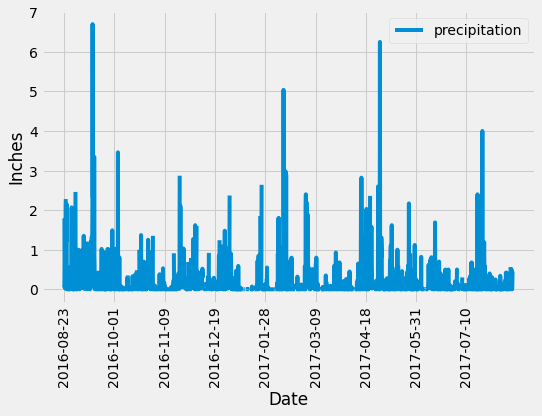

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()

# Calculate the date one year from the last date in data set.
last_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
year_ago = last_date - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date > year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(last_year, columns=['Date', 'precipitation'])
df.set_index('Date', inplace=True)

# Sort the dataframe by date
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
tick_vals = []
tick_labels = []

for x in range(0, len(df), 250):
    if x < len(df):
        tick_vals.append(x)
        tick_labels.append(df.index.values[x])

df.plot(figsize=(7.75,6));
plt.legend(loc='upper right')
plt.xticks(tick_vals, tick_labels, rotation="vertical")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()
plt.savefig("Images/last_12_mos_precip.png")
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
session.query(Stations.station).count()

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
row_cts_by_station = session.query(Measurements.station, Stations.name, func.count(Measurements.station)).\
    filter(Measurements.station == Stations.station).\
    group_by(Measurements.station).\
    order_by(func.count(Measurements.station).desc()).all()
row_cts_by_station

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
USC00519281_low = session.query(func.min(Measurements.tobs)).\
    filter(Measurements.station == 'USC00519281')
USC00519281_high = session.query(func.max(Measurements.tobs)).\
    filter(Measurements.station == 'USC00519281').all()
USC00519281_avg = session.query(func.avg(Measurements.tobs)).\
    filter(Measurements.station == 'USC00519281').all()

# Round the average figure for clean display
USC00519281_avg_map = round(USC00519281_avg[0][0],1)

# Print results
print(f"The lowest recorded temperature for most activate station USC00519281: {USC00519281_low[0][0]}.")
print(f"The highest recorded temperature for most activate station USC00519281: {USC00519281_high[0][0]}.")
print(f"The average recorded temperature for most activate station USC00519281: {USC00519281_avg_map}.")

The lowest recorded temperature for most activate station USC00519281: 54.0.
The highest recorded temperature for most activate station USC00519281: 85.0.
The average recorded temperature for most activate station USC00519281: 71.7.


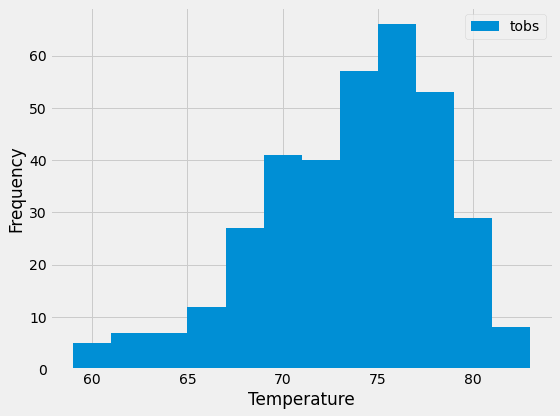

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_active = session.query(Measurements.tobs).\
    filter(Measurements.date > year_ago).\
    filter(Measurements.station == 'USC00519281').all()

# Save the query results as a Pandas DataFrame
active_df = pd.DataFrame(last_year_active, columns=['Temp'])

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(8,6))
plt.hist(active_df['Temp'], bins=12) 
plt.legend(labels=['tobs'],loc='upper right')
plt.ylabel('Frequency')
plt.xlabel('Temperature');
plt.tight_layout()
plt.savefig("Images/last_12_mos_temp_USC00519281.png")
plt.show()

# Close session

In [16]:
# Close Session
session.close()